# Directing customers 
Data analyst: Afshin 

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser 

### My CPU is arm-based and it generates a lot of useless warnings ###
import warnings
warnings.filterwarnings("ignore")

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Importing data set and EDA

In [3]:
# Importing data set
dataset = pd.read_csv("appdata10.csv")
dataset.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


#### EDA

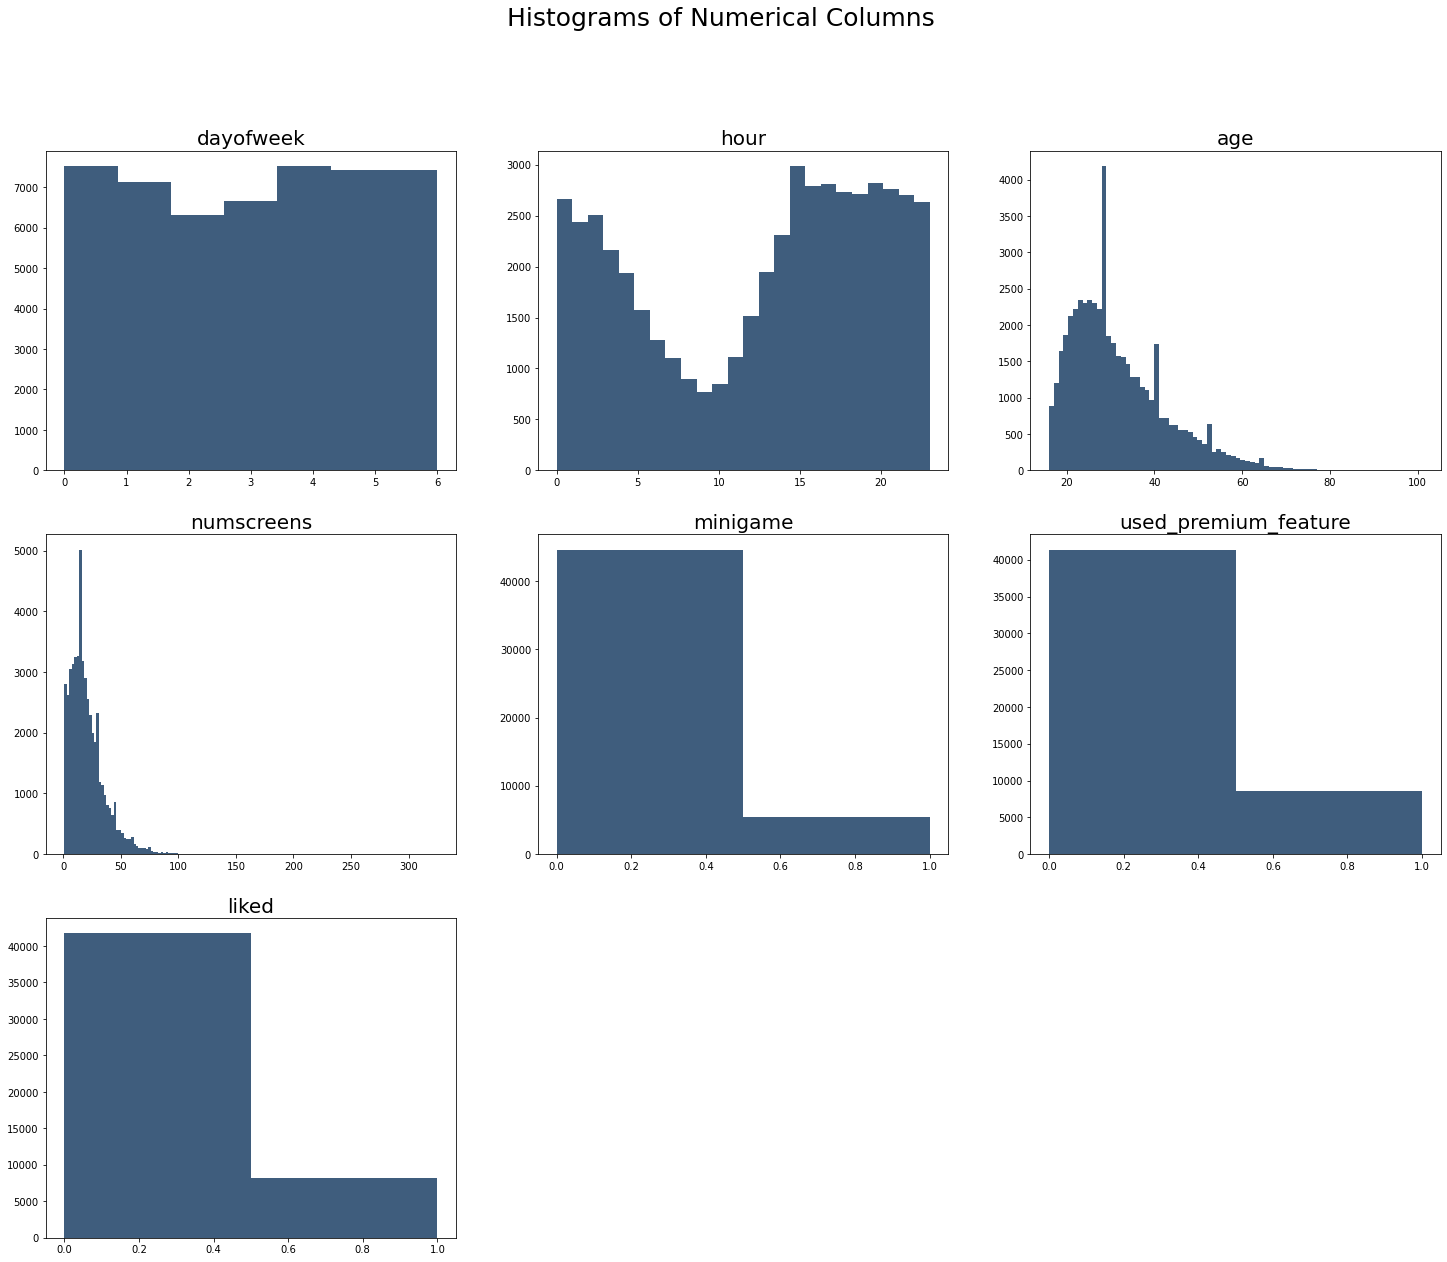

In [4]:
## Data cleaning: "hour" column is in string format, needs to be put in int format.
dataset["hour"] = dataset.hour.str.slice(1,3).astype(int)

dataset2 = dataset.copy().drop(columns = ["user", "screen_list", "enrolled_date", "first_open", "enrolled"])
dataset2.head()

## Histograms
plt.figure(figsize=(25, 20))
plt.suptitle("Histograms of Numerical Columns", 
             fontsize = 25)

for i in range(1, dataset2.shape[1]+1):
    plt.subplot(3, 3, i)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i - 1],
               fontsize = 20)
    
    vals = np.size(dataset2.iloc[:, i - 1].unique())
    plt.hist(dataset2.iloc[:, i-1],
             bins = vals,
             color = "#3F5D7D")

<AxesSubplot:title={'center':'Correlation with Response Variable'}>

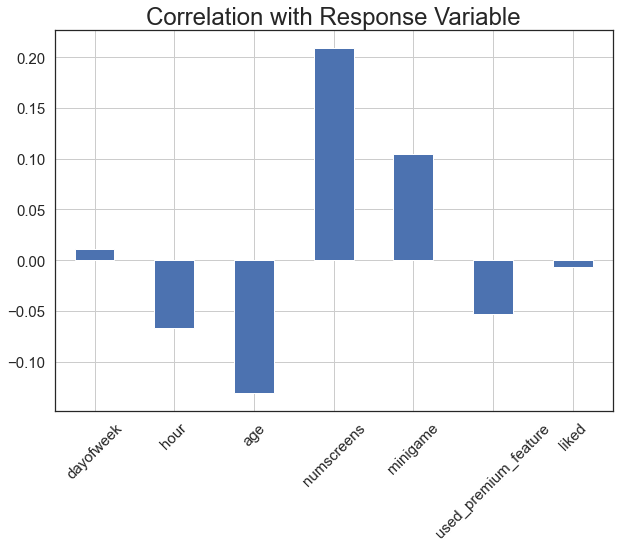

In [34]:
# Correlation with response
dataset2.corrwith(dataset.enrolled).plot.bar(figsize = (10, 7),
                                             title = "Correlation with Response Variable",
                                             fontsize = 15, 
                                             rot = 45,
                                             grid = True)

Text(0.5, 0.98, 'Correlation Matrix')

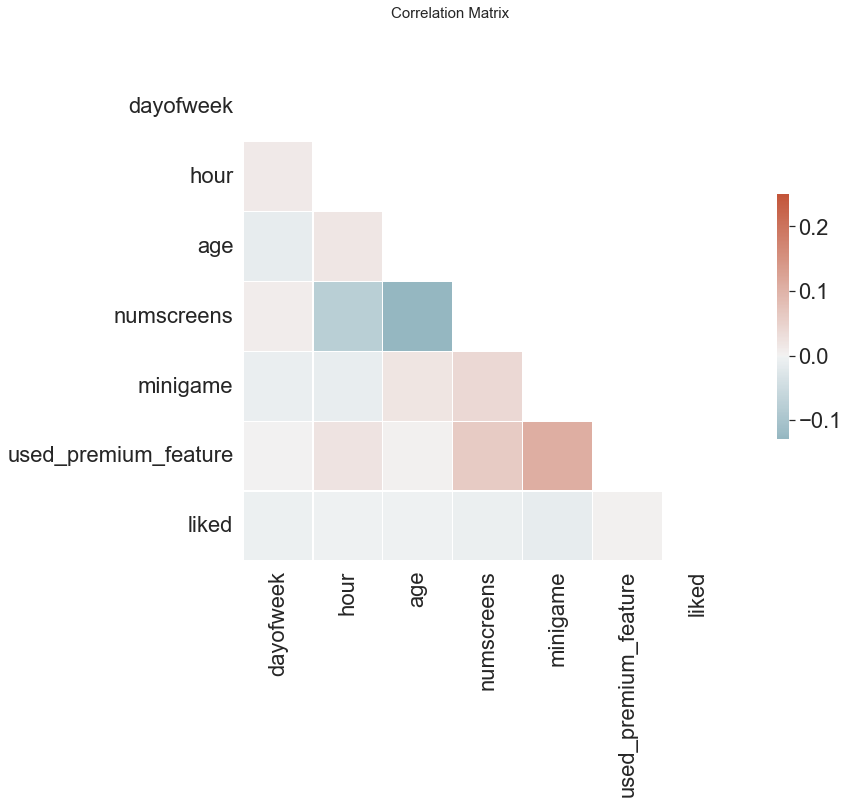

In [33]:
# Correlation matrice
sns.set(style = "white", font_scale = 2)

# Compute the correlation matrice
corr = dataset2.corr()

# Generate a mask for the upper traingle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f = plt.figure(figsize = (16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
          mask = mask,
          cmap = cmap,
          vmax = 0.25,
          center = 0,
          square = True,
          linewidths = 0.5,
          cbar_kws = {"shrink": 0.5})
f.suptitle("Correlation Matrix", fontsize = 15)


## Feature engineering 

#### Feature engineering: Response variable, enrolled

We need to find a reasoanble period during which our we will test our ML model.

In [40]:
print(dataset.dtypes, "\n\n")

# Changing first_open and enrolled_date from str into datetime64
dataset["first_open"] = [parser.parse(raw_data) for raw_data in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(raw_data) if isinstance(raw_data, str) else raw_data for raw_data in dataset["enrolled_date"]]

print("\n\n",dataset[["first_open", "enrolled_date"]])

In [62]:
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

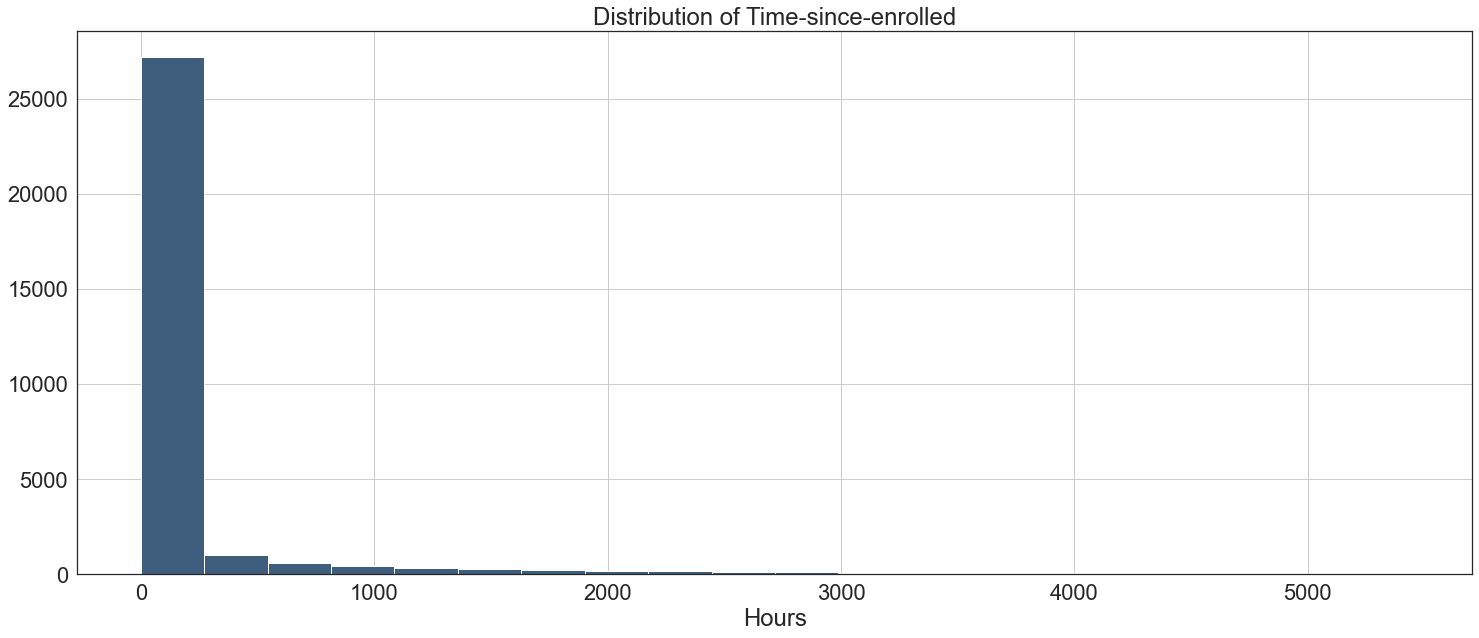

In [98]:
# enrolled_date - first_open (in hours) 
dataset["difference"] = (dataset.enrolled_date - dataset.first_open).astype("timedelta64[h]") 

# Creating histogram of difference
plt.figure(figsize = (25, 10))
plt.hist(dataset["difference"].dropna(),
         color = "#3F5D7D",
         bins = 20)

plt.title("Distribution of Time-since-enrolled")
plt.xlabel("Hours")
plt.grid()
plt.show()

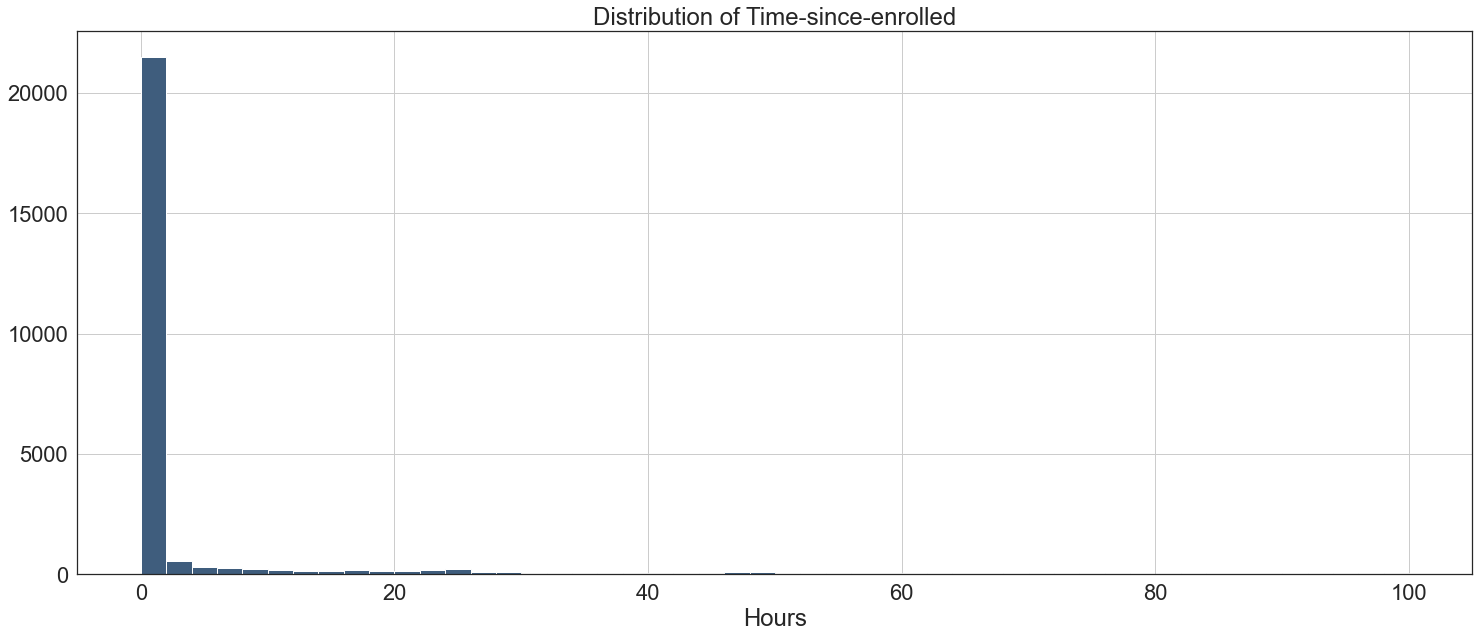

In [120]:
# We are creating a more detialed histogram since in the last one was right-skewed: range = (0, 100)
# enrolled_date - first_open (in hours) 
dataset["difference"] = (dataset.enrolled_date - dataset.first_open).astype("timedelta64[h]") 

# Creating histogram of difference
plt.figure(figsize = (25, 10))
plt.hist(dataset["difference"].dropna(),
         range = (0, 100),
         color = "#3F5D7D",
         bins = 50)

plt.title("Distribution of Time-since-enrolled")
plt.xlabel("Hours")
plt.grid()
plt.show()

In [125]:
# We are only considering users for whom difference < 48 hours (they enrolled at most 48 hours after first open)
dataset.loc[dataset.difference > 48, "enrolled"] = 0
dataset = dataset.drop(columns = ["user","difference", "enrolled_date", "first_open"])

AttributeError: 'DataFrame' object has no attribute 'difference'

#### Feature engineering: Screens